In [12]:
import importlib
import moc_cart_threaded as MOC

# import moc_cart as MOC
import shapely 
from scipy.interpolate import griddata

import matplotlib.pyplot as plt

In [13]:
from plot_scalar_flux import *

In [14]:
materials = {
    "reflector": MOC.Material(2.0, 1.80, 0.0, "reflector", "blue"),
    "scatterer": MOC.Material(2.0, 1.99, 0.0, "scatterer", "red"),
    "absorber": MOC.Material(10.0, 2.0, 0.0, "absorber", "green"),
    "air": MOC.Material(0.1, 0.006, 0.0, "air", (0.9, 0.97, 1.0, 0.3)),
    "air2": MOC.Material(0.1, 0.09, 0.0, "air", (0.9, 0.97, 1.0, 0.3)),
    "isotropic": MOC.Material(0.1, 0, 1, "isotropic", "purple"),
    "detector": MOC.Material(1.0, 0, 0, "detector", "yellow"),
    "vacuum": MOC.Material(0.0, 0.0, 0.0, "vacuum", "black"),
}

In [15]:
total_dx = 5

def make_blocks(x0, y0, dx=0.1, dy=0.1, total_dx=total_dx, total_dy=total_dx, material=materials["reflector"]):
    """Create a grid of blocks in the x-y plane."""

    if type(material) is str:
        material = materials[material]

    number_blocks_x = int(total_dx / dx)
    assert number_blocks_x == total_dx / dx, "total_dx must be a multiple of dx"
    
    number_blocks_y = int(total_dy / dy)
    assert number_blocks_y == total_dy / dy, "total_dy must be a multiple of dy"

    cells = {}
    for i_block in range(number_blocks_x):
        for j_block in range(number_blocks_y):
            x = x0 + i_block * dx
            y = y0 + j_block * dy
            cell = shapely.geometry.box(x, y, x + dx, y + dy)
            cell_data = MOC.CellData(cell, material)
            cells[cell] = cell_data

    return cells


def plot_mesh(cells):
    # fig, ax = plt.subplots()
    # for cell, cell_data in cells.items():
    #     shapely.plotting.plot_polygon(
    #         cell, color=cell_data.material.color, alpha=0.5, ax=ax
    #     )

    fig, ax = plt.subplots()
    material_handles = {}
    for cell, cell_data in cells.items():
        coords = np.array(cell.exterior.coords)
        polygon = plt.Polygon(
            coords,
            closed=True,
            facecolor=cell_data.material.color,
            alpha=0.5,
            edgecolor="black",
            linewidth=0.03,
        )
        ax.add_patch(polygon)

        mat_name = cell_data.material.name
        if mat_name not in material_handles:
            material_handles[mat_name] = mpatches.Patch(
                facecolor=cell_data.material.color,
                edgecolor="black",
                alpha=0.5,
                label=mat_name,
            )

    ax.autoscale_view()
    ax.set_aspect("equal")

    ax.legend(
        handles=list(material_handles.values()),
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
    )
    
    ax.set_xlabel("x (cm)")
    ax.set_ylabel("y (cm)")

    return fig, ax

In [16]:
dxs = [0.5, 0.2, 0.1]


def make_mesh(dx=0.1, block_size=2):

    sw = make_blocks(0, 0, dx=dx, dy=dx, total_dx=block_size, total_dy=block_size, material="scatterer")
    se = make_blocks(block_size, 0, dx=dx, dy=dx, total_dx=block_size, total_dy=block_size, material="air")
    nw = make_blocks(0, block_size, dx=dx, dy=dx, total_dx=block_size, total_dy=block_size, material="air")
    ne = make_blocks(block_size, block_size, dx=dx, dy=dx, total_dx=block_size, total_dy=block_size, material="isotropic")
    cells = {**sw, **se, **nw, **ne}
    return cells
# fig, ax = plot_mesh(cells)

In [17]:
def interpolate_to_ref_mesh(solution, reference_mesh):
    """Interpolate the scalar flux from the low resolution mesh to the high resolution mesh."""
    # Extract solution data from the solver
    cell_data = solution.cell_data_list
    centroids = [cell.cell.centroid for cell in cell_data]
    x = [c.x for c in centroids]
    y = [c.y for c in centroids]
    flux = [cell.prior_flux for cell in cell_data]

    ref_points = [
        (cell.cell.centroid.x, cell.cell.centroid.y)
        for cell in reference_mesh.cell_data_list
    ]
    # Linear interpolation
    interpolated_flux = griddata((x, y), flux, ref_points, method="linear")
    # Extrapolate using nearest for nan values
    nan_mask = np.isnan(interpolated_flux)
    if np.any(nan_mask):
        interpolated_flux[nan_mask] = griddata(
            (x, y), flux, np.array(ref_points)[nan_mask], method="nearest"
        )
    return np.array(interpolated_flux).flatten()


In [ ]:
quad = MOC.ProductQuadrature(16, 4)
ray_width = 0.01/2 
high_res_mesh = make_mesh(dx=0.01)
high_res_solver = MOC.CartesianMOC(high_res_mesh, quad, bc_west=1, ray_width=ray_width)
high_res_solver.solve()

Generating rays...
Rays generated in 494.19 seconds
Iter 0 error: 461.167111, time: 7.26 seconds
Iter 1 error: 34.361976, time: 7.34 seconds
Iter 2 error: 21.885804, time: 7.40 seconds
Iter 3 error: 16.559973, time: 7.35 seconds
Iter 4 error: 13.383812, time: 7.49 seconds
Iter 5 error: 11.213100, time: 7.50 seconds
Iter 6 error: 9.599310, time: 7.41 seconds
Iter 7 error: 8.330062, time: 7.52 seconds
Iter 8 error: 7.292601, time: 7.50 seconds
Iter 9 error: 6.421880, time: 7.47 seconds
Iter 10 error: 5.677703, time: 7.52 seconds
Iter 11 error: 5.033665, time: 7.57 seconds
Iter 12 error: 4.471419, time: 7.53 seconds
Iter 13 error: 3.977572, time: 7.53 seconds
Iter 14 error: 3.541912, time: 7.56 seconds
Iter 15 error: 3.156378, time: 7.58 seconds
Iter 16 error: 2.814419, time: 7.53 seconds
Iter 17 error: 2.510595, time: 7.52 seconds
Iter 18 error: 2.240309, time: 7.41 seconds
Iter 19 error: 1.999629, time: 7.47 seconds
Iter 20 error: 1.785154, time: 7.48 seconds
Iter 21 error: 1.593924, ti

In [ ]:
fig = plot_scalar_flux(high_res_solver)
fig.savefig("figures/03_high_res_flux.png", dpi=300, bbox_inches="tight")

In [ ]:
dxs = [0.5, 0.2, 0.1, 0.05]

low_res_fluxes = {}
number_of_cells = {}
for dx in dxs:
    low_res_mesh = make_mesh(dx=dx, block_size=2)
    number_of_cells[dx] = len(low_res_mesh)
    low_res_solver = MOC.CartesianMOC(low_res_mesh, quad, bc_west=1, ray_width=dx/2)
    low_res_solver.solve()
    
    low_res_flux = interpolate_to_ref_mesh(low_res_solver, high_res_solver)
    low_res_fluxes[dx] = low_res_flux

{0.5: 64, 0.2: 400, 0.1: 1600, 0.05: 6400}

In [ ]:
high_res_flux = [cell.prior_flux for cell in high_res_solver.cell_data_list]
number_high_res_cells = len(high_res_flux)

l2 = {}
for dx, low_res_flux in low_res_fluxes.items():
    l2[dx] = np.linalg.norm(low_res_flux - high_res_flux) / np.sqrt(number_high_res_cells)
    
l2

{0.5: np.float64(0.1272169976413413),
 0.2: np.float64(0.0406078605591396),
 0.1: np.float64(0.02371445284855242),
 0.05: np.float64(0.018097851831889188)}

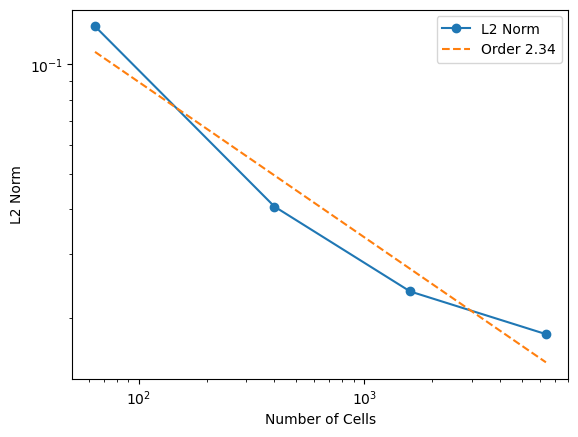

In [38]:
fig, ax = plt.subplots()
x = list(number_of_cells.values())
y = list(l2.values())

ax.plot(x, y, marker="o", label="L2 Norm")
ax.set_yscale("log")
ax.set_xscale("log")

order = np.polyfit(np.log(x), np.log(y), 1)
slope = order[0]
ax.plot(x, np.exp(order[1]) * np.array(x) ** slope, label=f"Order {-1/slope:.2f}", linestyle="--")
ax.legend()
ax.set_xlabel("Number of Cells")
ax.set_ylabel("L2 Norm")

for ext in [".svg", ".pdf"]:
    fig.savefig(f"figures/03_l2_norm{ext}", bbox_inches="tight")

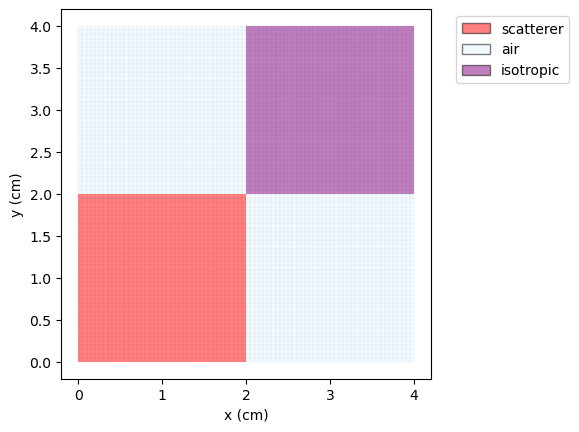

In [41]:
fig, ax = plot_mesh(low_res_mesh)
for ext in [".svg", ".pdf"]:
    fig.savefig(f"figures/03_low_res_mesh{ext}", bbox_inches="tight")